# PSD

Full traces

author: steeve.laquitaine@epfl.ch

**Execution duration:**   

* 15 mins (4 min recordings)
* 1h (entire recordings)  

**Data description**  
**in-vivo**:

* `Marques` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 30.0kHz
    * 20.25 min
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Neuropixels` (aligned with cortical column)
    * run: 2023_10_18
    * rat cortex S1
    * 384ch 
    * 40.0kHz
    * 10 min
    * "Spontaneous activity" (Only anesthetized condition)

Power is energy per time: can be compared between traces of different durations (sample length).

### Setup

Activate `spikeinterf..` venv

In [158]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
import scipy
from scipy.optimize import minimize
import spikeinterface.full as si_full
from concurrent.futures import ProcessPoolExecutor
import scipy

from scipy import signal


# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import amplitude
from src.nodes.study import power

matplotlib.rcParams['agg.path.chunksize'] = 10000


# SETUP PARAMETERS
SFREQ_VIVO = 30000          # sampling frequency
SFREQ_SILICO = 40000        # sampling frequency

# welch PSD plots
FILT_WIND_SIZE = 30000 # 30000 -> 1Hz freq. resol. # 512500 is tuned to get a freq. resol. of 0.1 Hz
FILT_WIND_OVERLAP = int(
    FILT_WIND_SIZE // 1.5
)  # // 2 # overlap raises computational cost.
FILT_WINDOW = "hann"


# SETUP DATASET COMFIG
# vivo
data_conf_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values()
RAW_PATH_vivo = data_conf_vivo["probe_wiring"]["output"]
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_vivo = data_conf_vivo["postprocessing"]["trace_snr"]
POWER_RAW_vivo = data_conf_vivo["analyses"]["traces"]["power"]["raw"]
POWER_PREP_vivo = data_conf_vivo["analyses"]["traces"]["power"]["preprocessed"]


# silico
data_conf_sili, param_conf_sili = get_config(
    "silico_neuropixels", "concatenated"
).values()
RAW_PATH_sili = data_conf_sili["probe_wiring"]["output"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_sili = data_conf_sili["postprocessing"]["trace_snr"]
POWER_RAW_sili = data_conf_sili["analyses"]["traces"]["power"]["raw"]
POWER_PREP_sili = data_conf_sili["analyses"]["traces"]["power"]["preprocessed"]


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
FIG_SIZE = (8, 3)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 30
#plt.rcParams['lines.linewidth'] = 1.1
#plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
#plt.rcParams['xtick.major.width'] = 1
#plt.rcParams['xtick.minor.size'] = 6
#plt.rcParams['xtick.major.size'] = 14
#plt.rcParams['ytick.major.size'] = 14
#plt.rcParams['ytick.major.width'] = 1
N_MAJOR_TICKS = 3
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-03 17:30:29,969 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-03 17:30:29,989 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-05-03 17:30:29,990 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-03 17:30:30,012 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Define custom functions

In [124]:
def save_traces_in_ctx(
    raw_traces_vivo, prep_traces_vivo, raw_traces_sili, prep_traces_sili
):

    # vivo (1m)
    np.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/1_vivo/marques/campaign/c26_fixed/traces_in_ctx",
        raw_traces_vivo,
    )
    np.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/preprocessed/1_vivo/marques/campaign/c26_fixed/traces_in_ctx",
        prep_traces_vivo,
    )

    # silico
    np.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/dataeng/recording/traces_in_ctx",
        raw_traces_sili,
    )

    np.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/preprocessed/traces_in_ctx",
        prep_traces_sili,
    )


def load_saved_traces_in_ctx():

    # vivo
    raw_traces_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/1_vivo/marques/campaign/c26_fixed/traces_in_ctx.npy"
    )
    prep_traces_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/preprocessed/1_vivo/marques/campaign/c26_fixed/traces_in_ctx.npy"
    )

    # silico
    raw_traces_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/dataeng/recording/traces_in_ctx.npy"
    )

    prep_traces_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/preprocessed/traces_in_ctx.npy"
    )
    return raw_traces_vivo, prep_traces_vivo, raw_traces_sili, prep_traces_sili


def get_site_power_marques_silico(trace, site):
    """calculate the power spectrum of the input trace

    Args:
        traces (np.ndarray): timepoints x sites voltage trace
        sfreq (_type_): voltage trace sampling frequency
        site: silent, automatically generated by ProcessPoolExecutor()

    Returns:
        _type_: _description_
    """
    (freq, power) = scipy.signal.periodogram(trace, SFREQ_SILICO, scaling="density")
    return np.array(power), np.array(freq)


def get_site_power_marques_vivo(trace, site):
    """calculate the power spectrum of the input trace

    Args:
        traces (np.ndarray): timepoints x sites voltage trace
        sfreq (_type_): voltage trace sampling frequency
        site: silent, automatically generated by ProcessPoolExecutor()

    Returns:
        _type_: _description_
    """
    (freq, power) = scipy.signal.periodogram(trace, SFREQ_VIVO, scaling="density")
    return np.array(power), np.array(freq)


def get_power_marques_silico_parallelized(traces: np.ndarray):
    """compute power spectrum density for Marques Silico
    using parallel computing

    Args:
        traces (np.ndarray): timepoints x sites voltage traces

    Returns:
        dict: frequencies x sites powers arraay and frequencies array
    """
    # takes 2 min (instead of 70 min w/o multiprocessing)
    nsites = traces.shape[1]

    # compute power for each site trace
    # in parallel with a pool of workers
    with ProcessPoolExecutor() as executor:
        power_by_site = executor.map(
            get_site_power_marques_silico,
            traces.T,
            np.arange(0, nsites, 1),
        )
    power_by_sites = list(power_by_site)

    # make an array with powers
    powersd = []
    for site in range(nsites):
        powersd.append(power_by_sites[site][0])
    powers = np.array(powersd)

    # store frequency domain
    freqs = power_by_sites[0][1]
    return {"power": powers, "freq": freqs}


def get_power_marques_vivo_parallelized(traces: np.ndarray):
    """compute power spectrum density for Marques Silico
    using parallel computing

    Args:
        traces (np.ndarray): timepoints x sites voltage traces

    Returns:
        dict: frequencies x sites powers arraay and frequencies array
    """
    # takes 2 min (instead of 70 min w/o multiprocessing)
    nsites = traces.shape[1]

    # compute power for each site trace
    # in parallel with a pool of workers
    with ProcessPoolExecutor() as executor:
        power_by_site = executor.map(
            get_site_power_marques_vivo,
            traces.T,
            np.arange(0, nsites, 1),
        )
    power_by_sites = list(power_by_site)

    # make an array with powers
    powersd = []
    for site in range(nsites):
        powersd.append(power_by_sites[site][0])
    powers = np.array(powersd)

    # store frequency domain
    freqs = power_by_sites[0][1]
    return {"power": powers, "freq": freqs}


def get_welch_psd_marques_silico_parallelized(traces: np.ndarray):
    """compute power spectrum density for Marques Silico
    using parallel computing

    Args:
        traces (np.ndarray): timepoints x sites voltage traces

    Returns:
        dict: frequencies x sites powers arraay and frequencies array
    """
    # takes 2 min (instead of 70 min w/o multiprocessing)
    nsites = traces.shape[1]

    # compute power for each site trace
    # in parallel with a pool of workers
    with ProcessPoolExecutor() as executor:
        power_by_site = executor.map(
            get_site_welch_psd_marques_silico,
            traces.T,
            np.arange(0, nsites, 1),
        )
    power_by_sites = list(power_by_site)

    # make an array with powers
    powersd = []
    for site in range(nsites):
        powersd.append(power_by_sites[site][0])
    powers = np.array(powersd)

    # store frequency domain
    freqs = power_by_sites[0][1]
    return {"power": powers, "freq": freqs}


def get_site_welch_psd_marques_silico(trace, site):
    """calculate the welch frequency powers in the input trace

    Args:
        traces (np.ndarray): timepoints x sites voltage trace
        sfreq (_type_): voltage trace sampling frequency
        site: silent, automatically generated by ProcessPoolExecutor()

    Returns:
        _type_: _description_
    """
    (freq, power) = signal.welch(
        trace,
        SFREQ_SILICO,
        window=FILT_WINDOW,
        nperseg=FILT_WIND_SIZE,
        noverlap=FILT_WIND_OVERLAP,
    )
    return np.array(power), np.array(freq)


def get_welch_psd_marques_vivo_parallelized(traces: np.ndarray):
    """compute power spectrum density for Marques Silico
    using parallel computing

    Args:
        traces (np.ndarray): timepoints x sites voltage traces

    Returns:
        dict: frequencies x sites powers arraay and frequencies array
    """
    # takes 2 min (instead of 70 min w/o multiprocessing)
    nsites = traces.shape[1]

    # compute power for each site trace
    # in parallel with a pool of workers
    with ProcessPoolExecutor() as executor:
        power_by_site = executor.map(
            get_site_welch_psd_marques_vivo,
            traces.T,
            np.arange(0, nsites, 1),
        )
    power_by_sites = list(power_by_site)

    # make an array with powers
    powersd = []
    for site in range(nsites):
        powersd.append(power_by_sites[site][0])
    powers = np.array(powersd)

    # store frequency domain
    freqs = power_by_sites[0][1]
    return {"power": powers, "freq": freqs}


def get_site_welch_psd_marques_vivo(trace, site):
    """calculate the welch frequency powers in the input trace

    Args:
        traces (np.ndarray): timepoints x sites voltage trace
        sfreq (_type_): voltage trace sampling frequency
        site: silent, automatically generated by ProcessPoolExecutor()

    Returns:
        _type_: _description_
    """
    (freq, power) = signal.welch(
        trace,
        SFREQ_VIVO,
        window=FILT_WINDOW,
        nperseg=FILT_WIND_SIZE,
        noverlap=FILT_WIND_OVERLAP,
    )
    return np.array(power), np.array(freq)


def save_psd_results(out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo):

    os.makedirs(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/",
        exist_ok=True,
    )
    os.makedirs(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/realism/1_vivo/marques/c26_fixed/postpro/",
        exist_ok=True,
    )

    # save sili
    np.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_raw_power_welch",
        out_raw_sili,
    )

    np.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_prep_power_welch",
        out_prep_sili,
    )

    # save vivo
    np.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/realism/1_vivo/marques/c26_fixed/postpro/full_raw_power_welch.npy",
        out_raw_vivo,
    )

    np.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/realism/1_vivo/marques/c26_fixed/postpro/full_prep_power_welch.npy",
        out_prep_vivo,
    )


def load_psd_results():

    # save sili
    out_raw_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_raw_power_welch.npy",
        allow_pickle=True,
    )
    out_raw_sili = out_raw_sili.item()

    out_prep_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/0_silico/neuropixels/concatenated_campaigns/postpro/realism/lfp/full_prep_power_welch.npy",
        allow_pickle=True,
    )
    out_prep_sili = out_prep_sili.item()

    # save vivo
    out_raw_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/realism/1_vivo/marques/c26_fixed/postpro/full_raw_power_welch.npy",
        allow_pickle=True,
    )
    out_raw_vivo = out_raw_vivo.item()

    out_prep_vivo = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/realism/1_vivo/marques/c26_fixed/postpro/full_prep_power_welch.npy",
        allow_pickle=True,
    )
    out_prep_vivo = out_prep_vivo.item()

    return out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo


def plot_power_for_layer(
    layer: str,
    site_layers_sili: list,
    site_layers_vivo: list,
    out_raw_vivo: dict,
    out_raw_sili: dict,
):
    """plot power spectrum density for the
    specified layer

    Args:
        layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
        site_layers_sili (list): layers of each in silico sites
        site_layers_vivo (list): layers of each in vivo sites
        out_raw_vivo (dict): _description_
        out_raw_sili (dict): _description_
    """

    fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

    # Select traces in layer

    # raw
    raw_power_sili_layer_i = out_raw_sili["power"][site_layers_sili == layer, :]
    raw_power_vivo_layer_i = out_raw_vivo["power"][site_layers_vivo == layer, :]

    # preprocessed
    prep_power_sili_layer_i = out_prep_sili["power"][site_layers_sili == layer, :]
    prep_power_vivo_layer_i = out_prep_vivo["power"][site_layers_vivo == layer, :]

    # Raw panel --------------------------------

    # VIVO
    psd_mean = np.mean(raw_power_vivo_layer_i, axis=0)
    axes[0].plot(
        out_raw_vivo["freq"],
        psd_mean,  # / psd_mean.mean(),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(raw_power_sili_layer_i, axis=0)
    axes[0].plot(
        out_raw_sili["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_xlabel("")
    # axes[0].set_ylabel("Power (ratio)")
    # axes[0].set_yscale("log")
    axes[0].set_xscale("log")
    axes[0].spines[["right", "top"]].set_visible(False)
    axes[0].set_ylim(YLIM_R)
    axes[0].set_xlim([-1, SFREQ_SILICO / 2])
    axes[0].tick_params(axis="x", which="minor", colors="black")
    axes[0].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[0].tick_params(which="both")
    axes[0].xaxis.set_major_locator(locmaj)
    axes[0].xaxis.set_minor_locator(locmin)
    axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # axes[0].set_xticklabels([])

    # # show minor ticks
    # locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    # locmin = matplotlib.ticker.LogLocator(
    #     base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    # )
    # axes[0].tick_params(which="both", width=1)
    # axes[0].xaxis.set_major_locator(locmaj)
    # axes[0].xaxis.set_minor_locator(locmin)
    # axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # Preprocessed panel --------------------------------

    # VIVO
    psd_mean = np.mean(prep_power_vivo_layer_i, axis=0)
    axes[1].plot(
        out_prep_vivo["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(prep_power_sili_layer_i, axis=0)
    axes[1].plot(
        out_prep_sili["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    # axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_xlabel("")
    axes[1].set_xscale("log")
    axes[1].spines[["left", "right", "top"]].set_visible(False)
    axes[1].set_yticklabels([])
    axes[1].set_yticks([])
    axes[1].set_xticks([])
    # axes[1].legend(**legend_cfg)
    axes[1].set_ylim(YLIM_P)

    # # show minor ticks
    # locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    # locmin = matplotlib.ticker.LogLocator(
    #     base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    # )
    # axes[1].tick_params(which="both", width=1)
    # axes[1].xaxis.set_major_locator(locmaj)
    # axes[1].xaxis.set_minor_locator(locmin)
    # axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    axes[1].set_xlim([-1, SFREQ_SILICO / 2])
    axes[1].tick_params(axis="x", which="minor", colors="black")
    axes[1].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[1].tick_params(which="both")
    axes[1].xaxis.set_major_locator(locmaj)
    axes[1].xaxis.set_minor_locator(locmin)
    axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # axes[0].set_xticklabels([])

    fig.tight_layout(**tight_layout_cfg)
    return axes

### (1s)Load recordings

In [125]:
# load raw traces
RawVivo = si.load_extractor(RAW_PATH_vivo)
RawSili = si.load_extractor(RAW_PATH_sili)

# load preprocessed traces
PreprocessedVivo = si.load_extractor(PREP_PATH_vivo)
PreprocessedSili = si.load_extractor(PREP_PATH_sili)

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/binaryrecordingextractor.py:78: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


#### (1s)Keep sites in cortex

In [126]:
# Keep traces from good sites (in cortex)

# silico
layers = ["L1", "L2_3", "L4", "L5", "L6"]
site_layers_sili = RawSili.get_property("layers")
site_layers_sili = [
    "L2_3" if l_i == "L2" or l_i == "L3" else l_i for l_i in site_layers_sili
]
IN_CTX = np.isin(site_layers_sili, layers)
sites_sili = np.where(IN_CTX)[0]

# vivo
site_layers_vivo = RawVivo.get_property("layers")
IN_CTX = np.isin(site_layers_vivo, layers)
sites_vivo = np.where(IN_CTX)[0]

#### Load traces in ctx (2m)

In [127]:
# (17m)Compute

# # Keep only raw traces from sites in cortex
# raw_traces_sili = RawSili.get_traces()
# raw_traces_vivo = RawVivo.get_traces()

# # Keep only preprocessed traces from sites in cortex
# prep_traces_sili = PreprocessedSili.get_traces()
# prep_traces_vivo = PreprocessedVivo.get_traces()

# # get sites in cortex
# # silico
# raw_traces_sili = raw_traces_sili[:, sites_sili]
# prep_traces_sili = prep_traces_sili[:, sites_sili]

# # vivo
# raw_traces_vivo = raw_traces_vivo[:, sites_vivo]
# prep_traces_vivo = prep_traces_vivo[:, sites_vivo]

# (1m) save
# save_traces_in_ctx(raw_traces_vivo, prep_traces_vivo, raw_traces_sili, prep_traces_sili)

# or load
raw_traces_vivo, prep_traces_vivo, raw_traces_sili, prep_traces_sili = (
    load_saved_traces_in_ctx()
)

In [128]:
# keep only the layers
site_layers_sili = np.array(site_layers_sili)[sites_sili]
site_layers_vivo = np.array(site_layers_vivo)[sites_vivo]

### (1s)Welch psd

In [129]:
# (50m) Compute

# # raw
# out_raw_sili = get_welch_psd_marques_silico_parallelized(raw_traces_sili)
# out_raw_vivo = get_welch_psd_marques_vivo_parallelized(raw_traces_vivo)

# # preprocessed
# out_prep_sili = get_welch_psd_marques_silico_parallelized(prep_traces_sili)
# out_prep_vivo = get_welch_psd_marques_vivo_parallelized(prep_traces_vivo)

# # save
# save_psd_results(out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo)

# or load
out_raw_sili, out_prep_sili, out_raw_vivo, out_prep_vivo = load_psd_results()

#### (2m) Plot column

The PSD is averaged over sites and divided by the total power over frequencies.

In [133]:
# (11s) normalize by total power
psd_mean_raw_vivo = np.sum(out_raw_vivo["power"], axis=0)
psd_mean_raw_sili = np.sum(out_raw_sili["power"], axis=0)
psd_mean_prep_vivo = np.sum(out_prep_vivo["power"], axis=0)
psd_mean_prep_sili = np.sum(out_prep_sili["power"], axis=0)

/tmp/ipykernel_124448/1195818581.py:31: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[0].set_xlim([-1, SFREQ_SILICO / 2])
/tmp/ipykernel_124448/1195818581.py:90: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[1].set_xlim([-1, SFREQ_SILICO / 2])


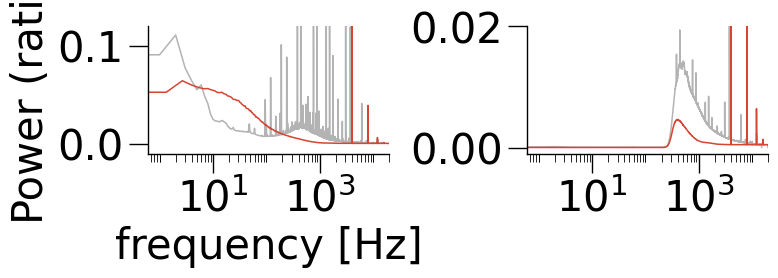

In [148]:
# takes 2 mins
# YLIM_R = [-5, 100]
# YLIM_P = [-0.5, 10]
YLIM_R = [-0.01, 0.12]
YLIM_P = [-0.001, 0.02]
N_MAJOR_TICKS = 4

fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

# Raw panel (8 secs) --------------------------------

# VIVO
# 3 secs
axes[0].plot(
    out_raw_vivo["freq"],
    psd_mean_raw_vivo,  # / psd_mean_raw_vivo.mean(),
    color=COLOR_VIVO,
    label="vivo",
)

# SILICO
axes[0].plot(
    out_raw_sili["freq"],
    psd_mean_raw_sili,  # / np.mean(psd_mean_raw_sili),
    color=COLOR_SILI,
    label="silico",
)

# legend
axes[0].set_xscale("log")
axes[0].set_xlim([-1, SFREQ_SILICO / 2])
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylim(YLIM_R)
axes[0].set_ylabel("Power (ratio)")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].tick_params(axis="x", which="minor", colors="black")
axes[0].tick_params(axis="x", which="major", colors="black")

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[0].tick_params(which="both")
axes[0].xaxis.set_major_locator(locmaj)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# axes[0].set_xticklabels([])

# Preprocessed panel ******************

# VIVO
axes[1].plot(
    out_prep_vivo["freq"],
    psd_mean_prep_vivo,  # / np.mean(psd_mean_prep_vivo),
    color=COLOR_VIVO,
    label="vivo",
)

# SILICO
axes[1].plot(
    out_prep_sili["freq"],
    psd_mean_prep_sili,  # / np.mean(psd_mean_prep_sili),
    color=COLOR_SILI,
    label="silico",
)

# legend
axes[1].set_xscale("log")
axes[1].spines[["right", "top"]].set_visible(False)
axes[1].legend(**legend_cfg)

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[1].tick_params(which="both")
axes[1].xaxis.set_major_locator(locmaj)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# axes[1].set_xticklabels([])
# axes[1].set_yticks([])
# axes[1].set_yticklabels([])
axes[1].set_ylim(YLIM_P)
axes[1].set_xlim([-1, SFREQ_SILICO / 2])

fig.tight_layout(**tight_layout_cfg)

# clear legend
axes[1].get_legend().remove()

# save
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_column_raw_welch.svg",
    **savefig_cfg
)

#### plot layer 1

/tmp/ipykernel_124448/1766324380.py:59: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[0].set_xlim([-1, SFREQ_SILICO / 2])
/tmp/ipykernel_124448/1766324380.py:127: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[1].set_xlim([-1, SFREQ_SILICO / 2])


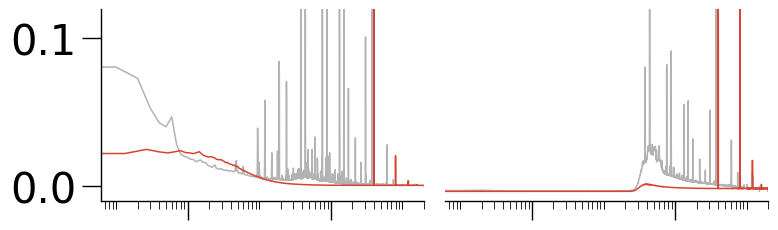

In [155]:
# takes 50 secs
axes = plot_power_for_layer(
    "L1", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

# save
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_layer1_column_raw_welch.svg",
    **savefig_cfg
)

#### plot layer 2/3

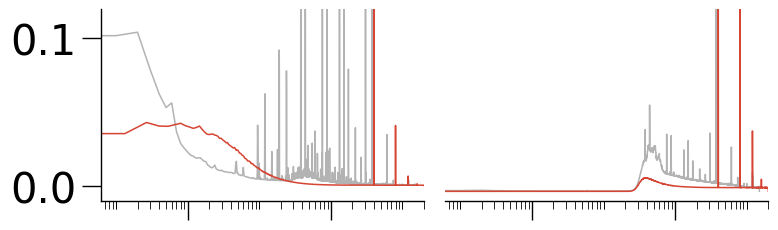

In [157]:
# takes 50 secs
axes = plot_power_for_layer(
    "L2_3", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

plt.savefig(
    "figures/2_realism/4_power/pdf/marques/marques_40m_psd_layer2_3_column_raw_welch.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_layer2_3_column_raw_welch.svg",
    **savefig_cfg
)

#### plot layer 4

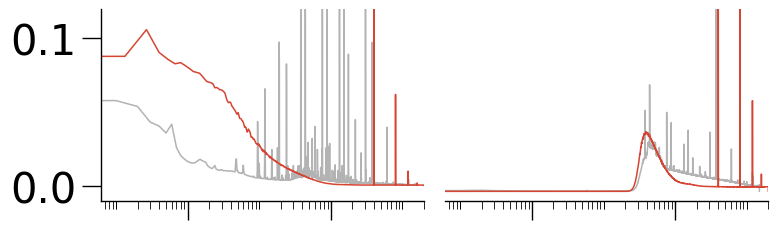

In [159]:
# takes 50 secs
axes = plot_power_for_layer(
    "L4", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_layer4_column_raw_welch.svg",
    **savefig_cfg
)

#### plot layer 5

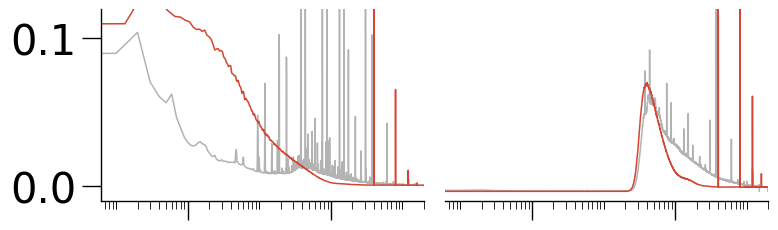

In [160]:
# takes 50 secs
axes = plot_power_for_layer(
    "L5", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_layer5_column_raw_welch.svg",
    **savefig_cfg
)

#### plot layer 6

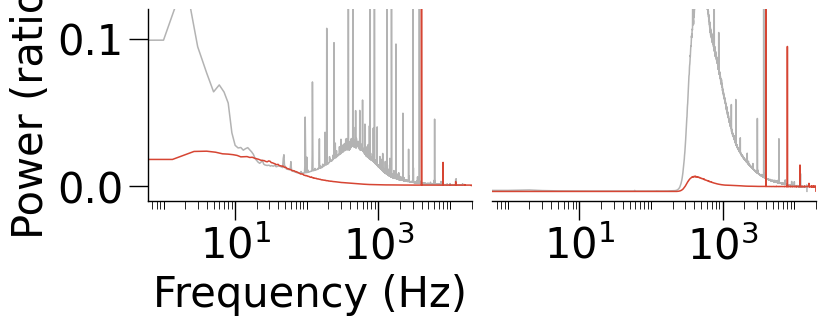

In [161]:
# takes 50 secs
axes = plot_power_for_layer(
    "L6", site_layers_sili, site_layers_vivo, out_raw_vivo, out_raw_sili
)
axes[0].set_ylabel("Power (ratio)")
axes[0].set_xlabel("Frequency (Hz)")

plt.savefig(
    "figures/2_realism/4_power/svg/marques/marques_40m_psd_layer6_column_raw_welch.svg",
    **savefig_cfg
)

# references

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
